Load data

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from scipy.stats import entropy, wasserstein_distance, skew, kurtosis
from dtaidistance import dtw
from numba import njit, prange
import random
from mpl_toolkits.mplot3d import Axes3D
import bisect

solargen = pd.read_excel('./data/Belgium_solar_generation_probability_density.xlsx', sheet_name='Solar_profiles',header=None)
solargen = solargen
solargen = solargen.drop(index=0, columns=0).reset_index(drop=True)
solargen.index = range(1, len(solargen) + 1)
solargen = solargen.iloc[:, :-1]

def normalize_to_charger_kw(df):
    df_normalized = df / df.max()
    return df_normalized

# Select 1 charging profile
chargingprofile1 = pd.read_csv('data/yearly_charging_profile1.csv', header=None)
chargingprofile1 = chargingprofile1.drop(index=0, columns=0).reset_index(drop=True)
chargingprofile1.index = range(1, len(chargingprofile1) + 1)
chargingprofile1 = normalize_to_charger_kw(chargingprofile1)
chargingprofile1_kwh = chargingprofile1/4

# Select small consumer = 1000 kWh, medium consumer = 2500 kWh, large consumer = 6500 kWh
consumer1 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad57.csv', header=None)
consumer1.columns = range(1, consumer1.shape[1] + 1)
consumer1.index = range(1, len(consumer1) + 1)

consumer2 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad940.csv', header=None)
consumer2.columns = range(1, consumer2.shape[1] + 1)
consumer2.index = range(1, len(consumer2) + 1)

consumer3 = pd.read_csv('./data/Fluvius load profiles type 1 consumer/Type1consumerLoad234.csv', header=None)
consumer3.columns = range(1, consumer3.shape[1] + 1)
consumer3.index = range(1, len(consumer3) + 1)

In [81]:
def sum_columns(df):
    # Sum the values of each column and return as a Series
    return df.sum()

Visualize profiles

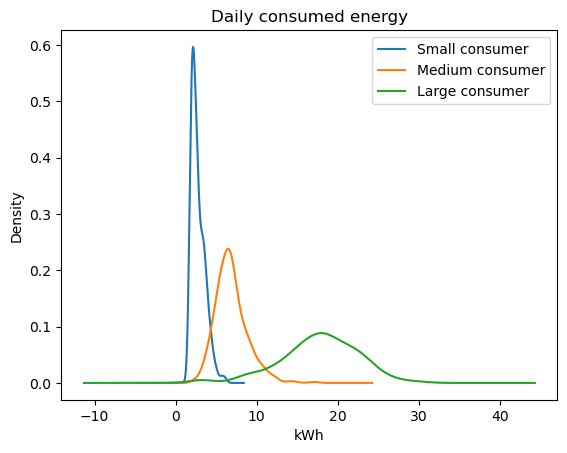

In [86]:
daily_load1 = sum_columns(consumer1)
daily_load2 = sum_columns(consumer2)
daily_load3 = sum_columns(consumer3)
ax = daily_load1.plot.density(label = 'Small consumer')
daily_load2.plot.density(label = 'Medium consumer')
daily_load3.plot.density(label = 'Large consumer')
ax.set_title('Daily consumed energy')
ax.set_xlabel('kWh')
ax.legend()



2.756583561643836
6.850194520547945
17.75960819178082


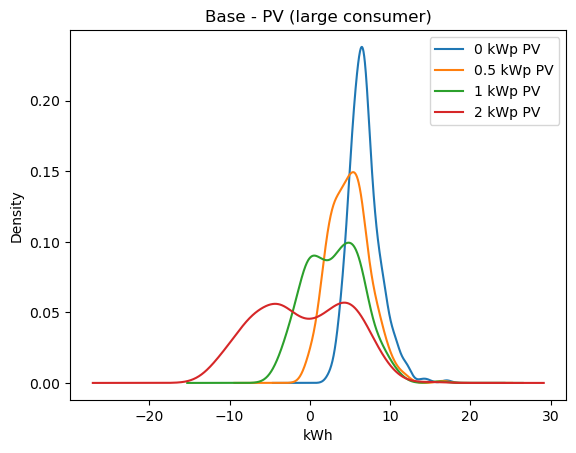

In [142]:

kwp_set = [0, 0.5, 1, 2]
kw_set = [0,1, 2, 3]

for kwp in kwp_set:
    net_load = consumer2*4 - kwp*solargen
    net_load = pd.Series(sum_columns(net_load/4))
    ax = net_load.plot.kde(label = f'{kwp} kWp PV')      
ax.legend()
ax.set_title('Base - PV (large consumer)')
ax.set_xlabel('kWh')

# for kw in kw_set:
#     net_load = consumer2*4 + kw*chargingprofile1
#     net_load = pd.Series(sum_columns(net_load/4))
#     print(sum_columns(kw*chargingprofile1/4).mean())
#     ax = net_load.plot.kde(label = f'{kw} kW EV')      
# ax.legend()
# ax.set_title('Base + EV (large consumer)')
# ax.set_xlabel('kWh')
print("\n")
print(sum_columns(consumer1).mean())
print(sum_columns(consumer2).mean())
print(sum_columns(consumer3).mean())



Metrics of EV+PV per consumer

In [ ]:
def plot_multiple_heatmaps(matrix_list, moments, cols=2):
    kwp_set = np.linspace(0, 10, 100) 
    kw_set = np.linspace(0, 23, 100)
    
    num_heatmaps = len(matrix_list)
    rows = -(-num_heatmaps // cols)  
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 6))
    axes = axes.flatten()  

    for i, (matrix, moment) in enumerate(zip(matrix_list, moments)):
        ax = axes[i]
        matrix = matrix[::-1]  # Reverse the matrix rows
        y_labels = list(map(str, kwp_set))
        y_labels.reverse()
        x_labels = list(map(str, kw_set))

        sns.heatmap(
            matrix, annot=False, cmap='coolwarm', cbar=True, 
            xticklabels=x_labels, yticklabels=y_labels, 
            ax=ax, annot_kws={"size": 12}
        )

        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=16)

        title = (
            f'{moment} [kWh]' if moment in [
                "Mean", "Standard deviation", "Minimum", "Maximum", 
                "Total energy consumed", "0,05 quantile", "0,95 quantile"
            ] else moment
        )
        ax.set_title(title, fontsize=18, weight='bold')
        ax.set_ylabel("PV: kWp values", fontsize=14)
        ax.set_xlabel("EV: charger kW values", fontsize=14)

        x_tick_positions = np.linspace(0, len(kw_set) - 1, 24, dtype=int)
        y_tick_positions = np.linspace(0, len(kwp_set) - 1, 11, dtype=int)
        
        # Convert whole numbers (0-23) into string labels
        x_tick_labels = [str(i) for i in range(24)]
        y_tick_labels = [str(i) for i in range(11)][::-1]  # Reverse to match y-axis

        ax.set_xticks(x_tick_positions)
        ax.set_xticklabels(x_tick_labels)

        ax.set_yticks(y_tick_positions)
        ax.set_yticklabels(y_tick_labels)

    for i in range(len(matrix_list), len(axes)):
        axes[i].axis('off')

    plt.tight_layout() 
    plt.show()

In [127]:
def daily_metrics(consumer):    
    kwp_set = np.linspace(0, 10, 100) # From 0 to 10 with 100 steps
    kw_set = np.linspace(0, 23, 100)

    nb_kwp = len(kwp_set)
    nb_kw = len(kw_set)

    index =  ['Min', 'Max', 'Mean', 'Std', 'Skew', 'Kurt', 'Var', 'Load', 'q5', 'q95', 'Entropy', 'KL', 'TVD', 'Wasserstein']
    metrics = pd.DataFrame(index=index, columns=['Matrix'], dtype=object)

    matrix_min = np.zeros((nb_kwp, nb_kw))
    matrix_max = np.zeros((nb_kwp, nb_kw))
    matrix_mean = np.zeros((nb_kwp, nb_kw))
    matrix_std = np.zeros((nb_kwp, nb_kw))
    matrix_skew = np.zeros((nb_kwp, nb_kw))
    matrix_kurt = np.zeros((nb_kwp, nb_kw))
    matrix_var = np.zeros((nb_kwp, nb_kw))
    matrix_load = np.zeros((nb_kwp, nb_kw))
    matrix_q5 = np.zeros((nb_kwp, nb_kw))
    matrix_q95 = np.zeros((nb_kwp, nb_kw))
    matrix_entropy = np.zeros((nb_kwp, nb_kw))
    matrix_KL = np.zeros((nb_kwp, nb_kw))
    matrix_total_distance = np.zeros((nb_kwp, nb_kw))
    matrix_wasserstein_distance = np.zeros((nb_kwp, nb_kw))

    consumer_flat = sum_columns(consumer).to_numpy()
    # solargen_flat = sum_columns(solargen)
    # chargingprofile1_flat = sum_columns(chargingprofile1)

    for i, kwp in enumerate(kwp_set):
        print('iteration :', i, ' of ', nb_kwp)
        for j, kw in enumerate(kw_set):

            net_load = consumer*4 - kwp*solargen + kw*chargingprofile1
            net_load = net_load/4
            net_load = sum_columns(net_load).to_numpy()
        
    
            matrix_min[i,j] = net_load.min()
            matrix_max[i,j] = net_load.max()
            matrix_mean[i,j] = net_load.mean()
            matrix_std[i,j] = net_load.std()
            matrix_skew[i,j] = pd.Series(net_load).skew()
            matrix_kurt[i,j] = pd.Series(net_load).kurt()
            matrix_var[i,j] = pd.Series(net_load).var()
            matrix_load[i,j] = net_load.sum()
            matrix_q5[i,j] = pd.Series(net_load).quantile(.05)
            matrix_q95[i,j] = pd.Series(net_load).quantile(.95)
            
            #Compute common bin width
            hist_base, bin_edges_base = np.histogram(consumer_flat,bins='auto',density=False)
            bin_width = bin_edges_base[1] - bin_edges_base[0]
            adjusted_min = consumer_flat.min()
            while adjusted_min > net_load.min():
                adjusted_min -= bin_width
            adjusted_max = consumer_flat.max()
            while adjusted_max < net_load.max():
                adjusted_max += bin_width

            bin_edges_net_load = np.arange(adjusted_min, adjusted_max + bin_width, bin_width)
            bin_edges_net_load = [ round(elem, 5) for elem in bin_edges_net_load ]
            bin_edges_base = [ round(elem, 5) for elem in bin_edges_base ]

            hist_net_load, _ = np.histogram(net_load,bins=bin_edges_net_load,density=False)
            
            
            # Turn hist into 'PDF' (counts to probabilities)
            hist_net_load = hist_net_load/hist_net_load.sum()
            hist_base = hist_base/hist_base.sum()
            
            #S_max = np.log2(nb_bins)
            matrix_entropy[i,j] = entropy(hist_net_load,base=2) # /S_max
            epsilon = 1e-10
            common_bin_edges = np.union1d(bin_edges_base, bin_edges_net_load)
            hist_base, bin_edges_base = np.histogram(consumer_flat,bins=common_bin_edges,density=False)
            hist_net_load, bin_edges_net_load = np.histogram(net_load,bins=common_bin_edges,density=False)

            hist_net_load = hist_net_load/hist_net_load.sum()
            hist_base = hist_base/hist_base.sum()
            
            hist_base = hist_base+epsilon
            hist_net_load = hist_net_load+epsilon

            matrix_KL[i,j] = entropy(pk=hist_base, qk=hist_net_load, base=2)

            tvd = 0.5 * np.sum(np.abs(hist_base - hist_net_load))
            matrix_total_distance[i,j] = tvd

            midpoints_net = (bin_edges_net_load[:-1] + bin_edges_net_load[1:]) / 2
            midpoints_base = (bin_edges_base[:-1] + bin_edges_base[1:]) / 2
            # midpoints = (common_bin_edges[:-1] + common_bin_edges[1:]) / 2
            # wasserstein_dist = wasserstein_distance(midpoints, midpoints, u_weights=hist_base, v_weights=hist_net_load)
            wasserstein_dist = wasserstein_distance(midpoints_base, midpoints_net, u_weights=hist_base, v_weights=hist_net_load)
            
            matrix_wasserstein_distance[i,j] = wasserstein_dist

    metrics.loc['Min', 'Matrix'] = matrix_min
    metrics.loc['Max', 'Matrix'] = matrix_max
    metrics.loc['Mean', 'Matrix'] = matrix_mean 
    metrics.loc['Std', 'Matrix'] = matrix_std 
    metrics.loc['Skew', 'Matrix'] = matrix_skew 
    metrics.loc['Kurt', 'Matrix'] = matrix_kurt 
    metrics.loc['Var', 'Matrix'] = matrix_var 
    metrics.loc['Load', 'Matrix'] = matrix_load 
    metrics.loc['q5', 'Matrix'] = matrix_q5 
    metrics.loc['q95', 'Matrix'] = matrix_q95 
    metrics.loc['Entropy', 'Matrix'] = matrix_entropy 
    metrics.loc['KL', 'Matrix'] = matrix_KL 
    metrics.loc['TVD', 'Matrix'] = matrix_total_distance 
    metrics.loc['Wasserstein', 'Matrix'] = matrix_wasserstein_distance 

    return metrics

In [128]:
print('CONSUMER1 started...')
daily_metrics_consumer_1 = daily_metrics(consumer1)
print('CONSUMER1 done!')

print('CONSUMER2 started...')
daily_metrics_consumer_2 = daily_metrics(consumer2)
print('CONSUMER2 done!')

print('CONSUMER3 started...')
daily_metrics_consumer_3 = daily_metrics(consumer3)
print('CONSUMER3 done!')

CONSUMER1 started...
iteration : 0  of  100
iteration : 1  of  100
iteration : 2  of  100
iteration : 3  of  100
iteration : 4  of  100
iteration : 5  of  100
iteration : 6  of  100
iteration : 7  of  100
iteration : 8  of  100
iteration : 9  of  100
iteration : 10  of  100
iteration : 11  of  100
iteration : 12  of  100
iteration : 13  of  100
iteration : 14  of  100
iteration : 15  of  100
iteration : 16  of  100
iteration : 17  of  100
iteration : 18  of  100
iteration : 19  of  100
iteration : 20  of  100
iteration : 21  of  100
iteration : 22  of  100
iteration : 23  of  100
iteration : 24  of  100
iteration : 25  of  100
iteration : 26  of  100
iteration : 27  of  100
iteration : 28  of  100
iteration : 29  of  100
iteration : 30  of  100
iteration : 31  of  100
iteration : 32  of  100
iteration : 33  of  100
iteration : 34  of  100
iteration : 35  of  100
iteration : 36  of  100
iteration : 37  of  100
iteration : 38  of  100
iteration : 39  of  100
iteration : 40  of  100
itera

C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\399833093.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Load'][0],daily_metrics_consumer_1.loc['Std'][0],daily_metrics_consumer_1.loc['Skew'][0],daily_metrics_consumer_1.loc['Kurt'][0],daily_metrics_consumer_1.loc['Var'][0],daily_metrics_consumer_2.loc['Load'][0],daily_metrics_consumer_2.loc['Std'][0],daily_metrics_consumer_2.loc['Skew'][0],daily_metrics_consumer_2.loc['Kurt'][0],daily_metrics_consumer_2.loc['Var'][0],daily_metrics_consumer_3.loc['Load'][0],daily_metrics_consumer_3.loc['Std'][0],daily_metrics_consumer_3.loc['Skew'][0],daily_metrics_consumer_3.loc['Kurt'][0],daily_metrics_consumer_3.loc['Var'][0]],["Yearly consumption small consumer","Standard deviation small consumer","Skewnes

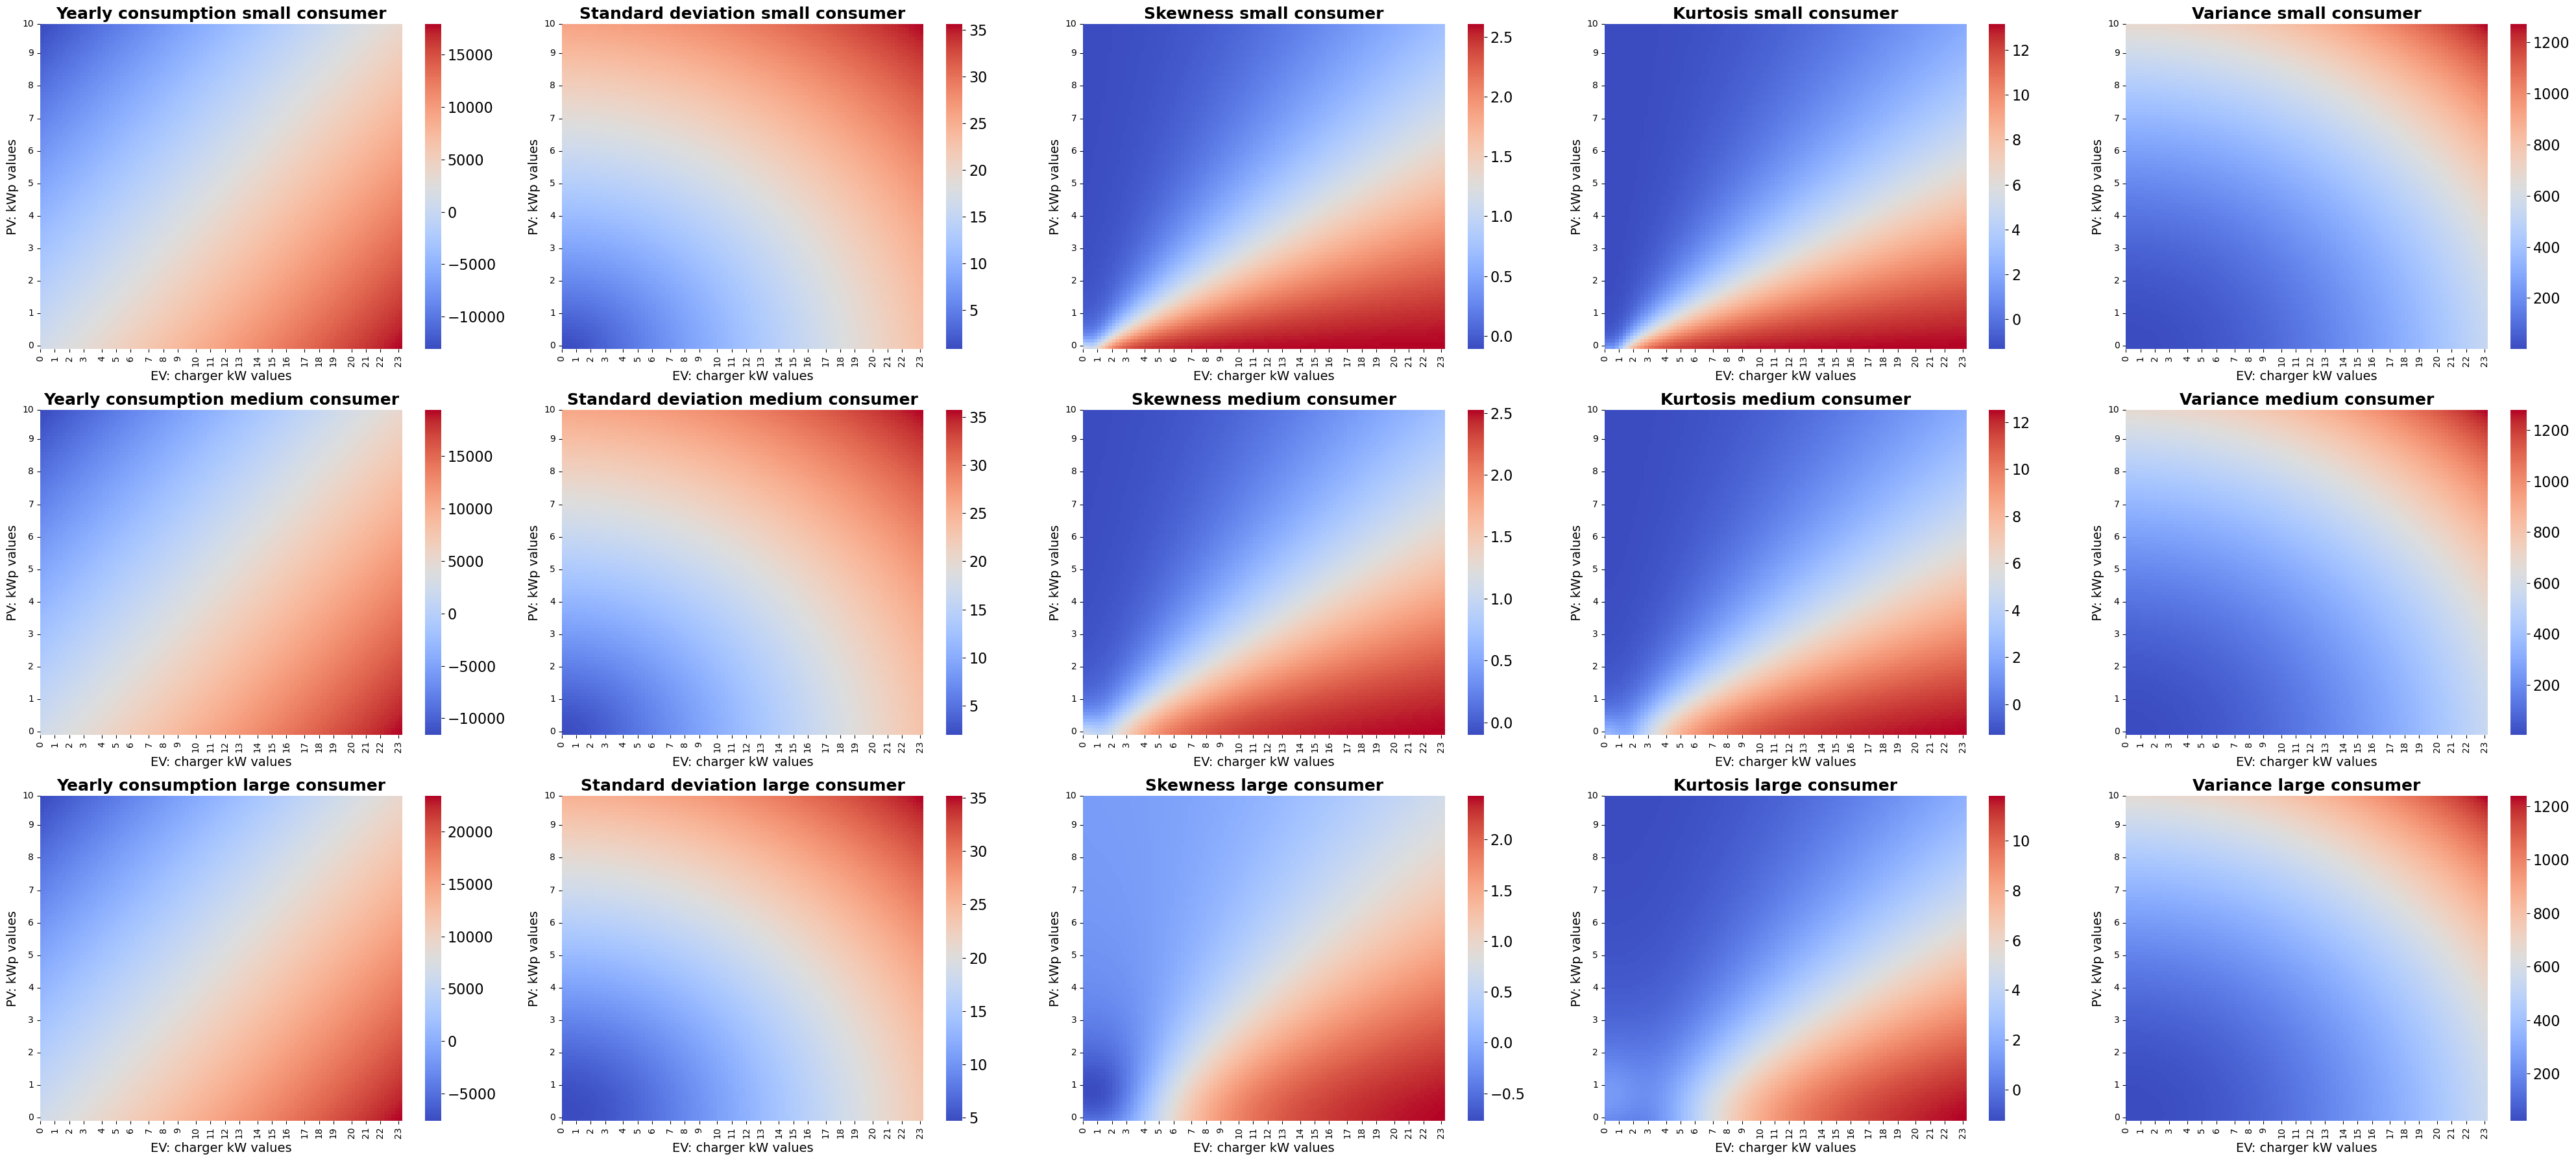

In [129]:
plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Load'][0],daily_metrics_consumer_1.loc['Std'][0],daily_metrics_consumer_1.loc['Skew'][0],daily_metrics_consumer_1.loc['Kurt'][0],daily_metrics_consumer_1.loc['Var'][0],daily_metrics_consumer_2.loc['Load'][0],daily_metrics_consumer_2.loc['Std'][0],daily_metrics_consumer_2.loc['Skew'][0],daily_metrics_consumer_2.loc['Kurt'][0],daily_metrics_consumer_2.loc['Var'][0],daily_metrics_consumer_3.loc['Load'][0],daily_metrics_consumer_3.loc['Std'][0],daily_metrics_consumer_3.loc['Skew'][0],daily_metrics_consumer_3.loc['Kurt'][0],daily_metrics_consumer_3.loc['Var'][0]],["Yearly consumption small consumer","Standard deviation small consumer","Skewness small consumer","Kurtosis small consumer","Variance small consumer","Yearly consumption medium consumer","Standard deviation medium consumer","Skewness medium consumer","Kurtosis medium consumer","Variance medium consumer","Yearly consumption large consumer","Standard deviation large consumer","Skewness large consumer","Kurtosis large consumer","Variance large consumer"],cols=5)

C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\1903915582.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Load'][0], daily_metrics_consumer_1.loc['Std'][0], daily_metrics_consumer_1.loc['Skew'][0], daily_metrics_consumer_1.loc['Kurt'][0]], ["Yearly consumption [kWh]","Standard deviation [kWh]","Skewness [/]", "Kurtosis [/]"], cols=2)


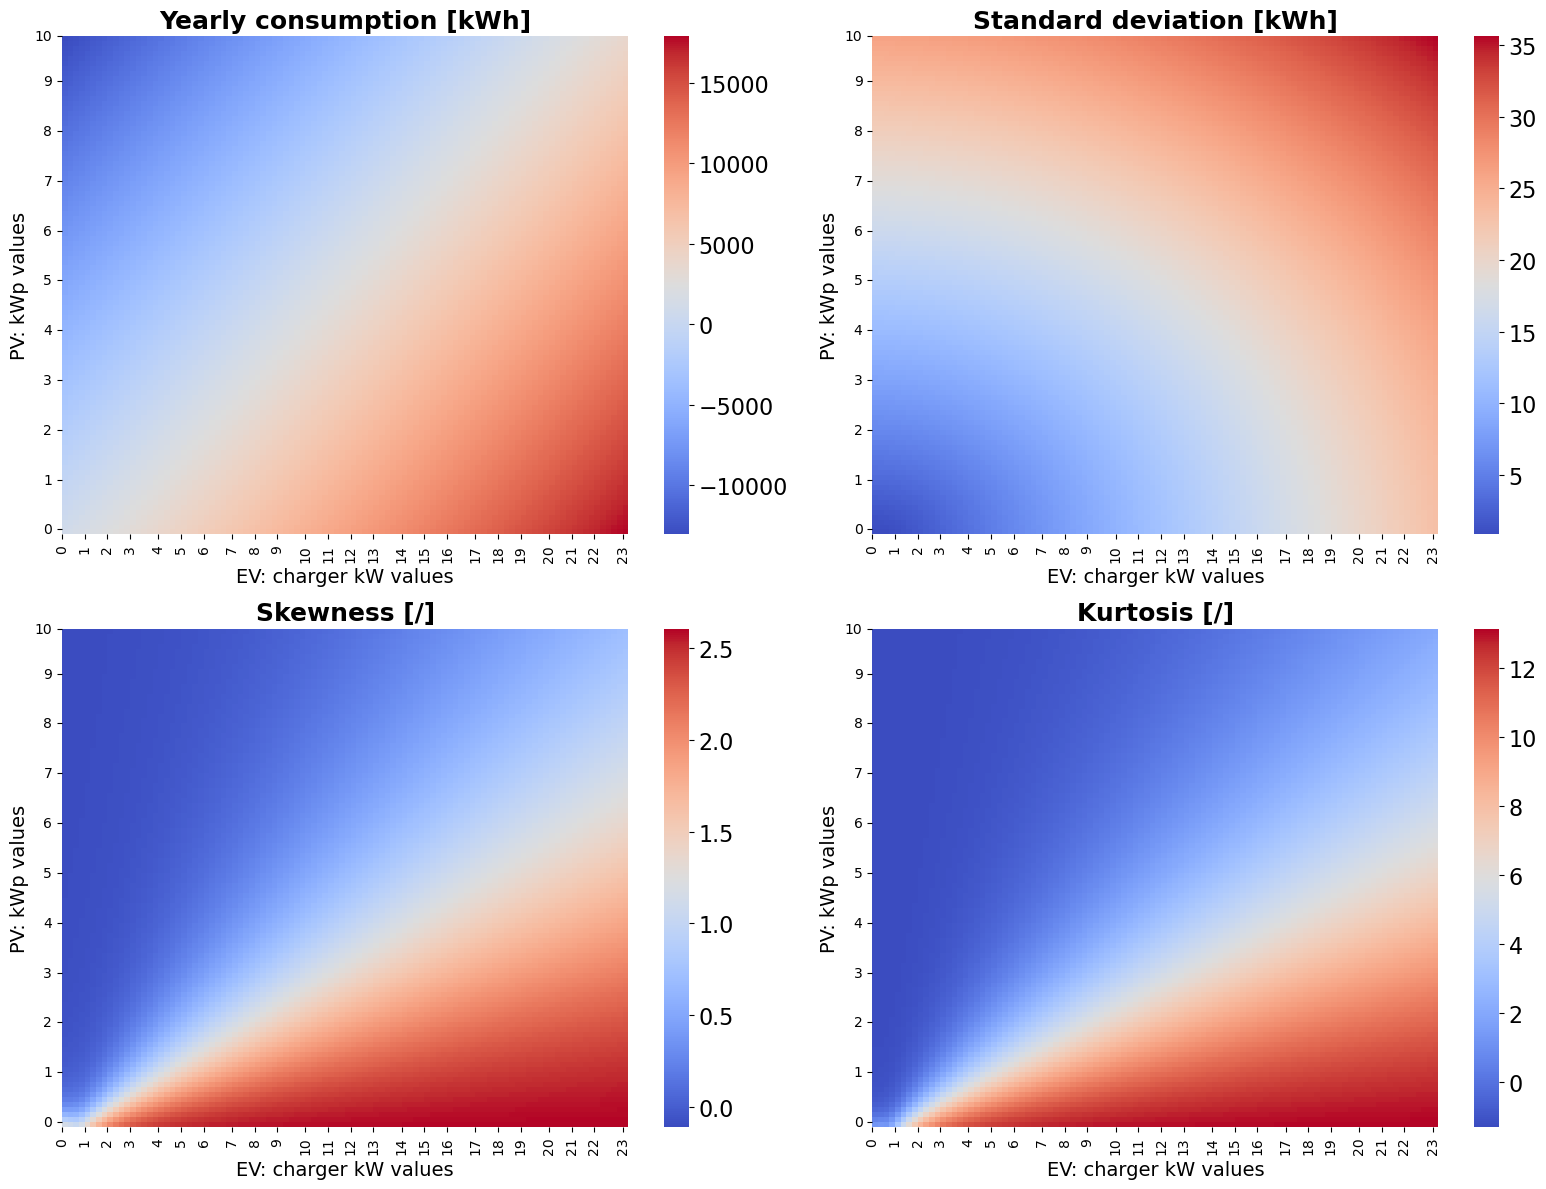

C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\1903915582.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_2.loc['Load'][0], daily_metrics_consumer_2.loc['Std'][0], daily_metrics_consumer_2.loc['Skew'][0], daily_metrics_consumer_2.loc['Kurt'][0]], ["Yearly consumption [kWh]","Standard deviation [kWh]","Skewness [/]", "Kurtosis [/]"], cols=2)


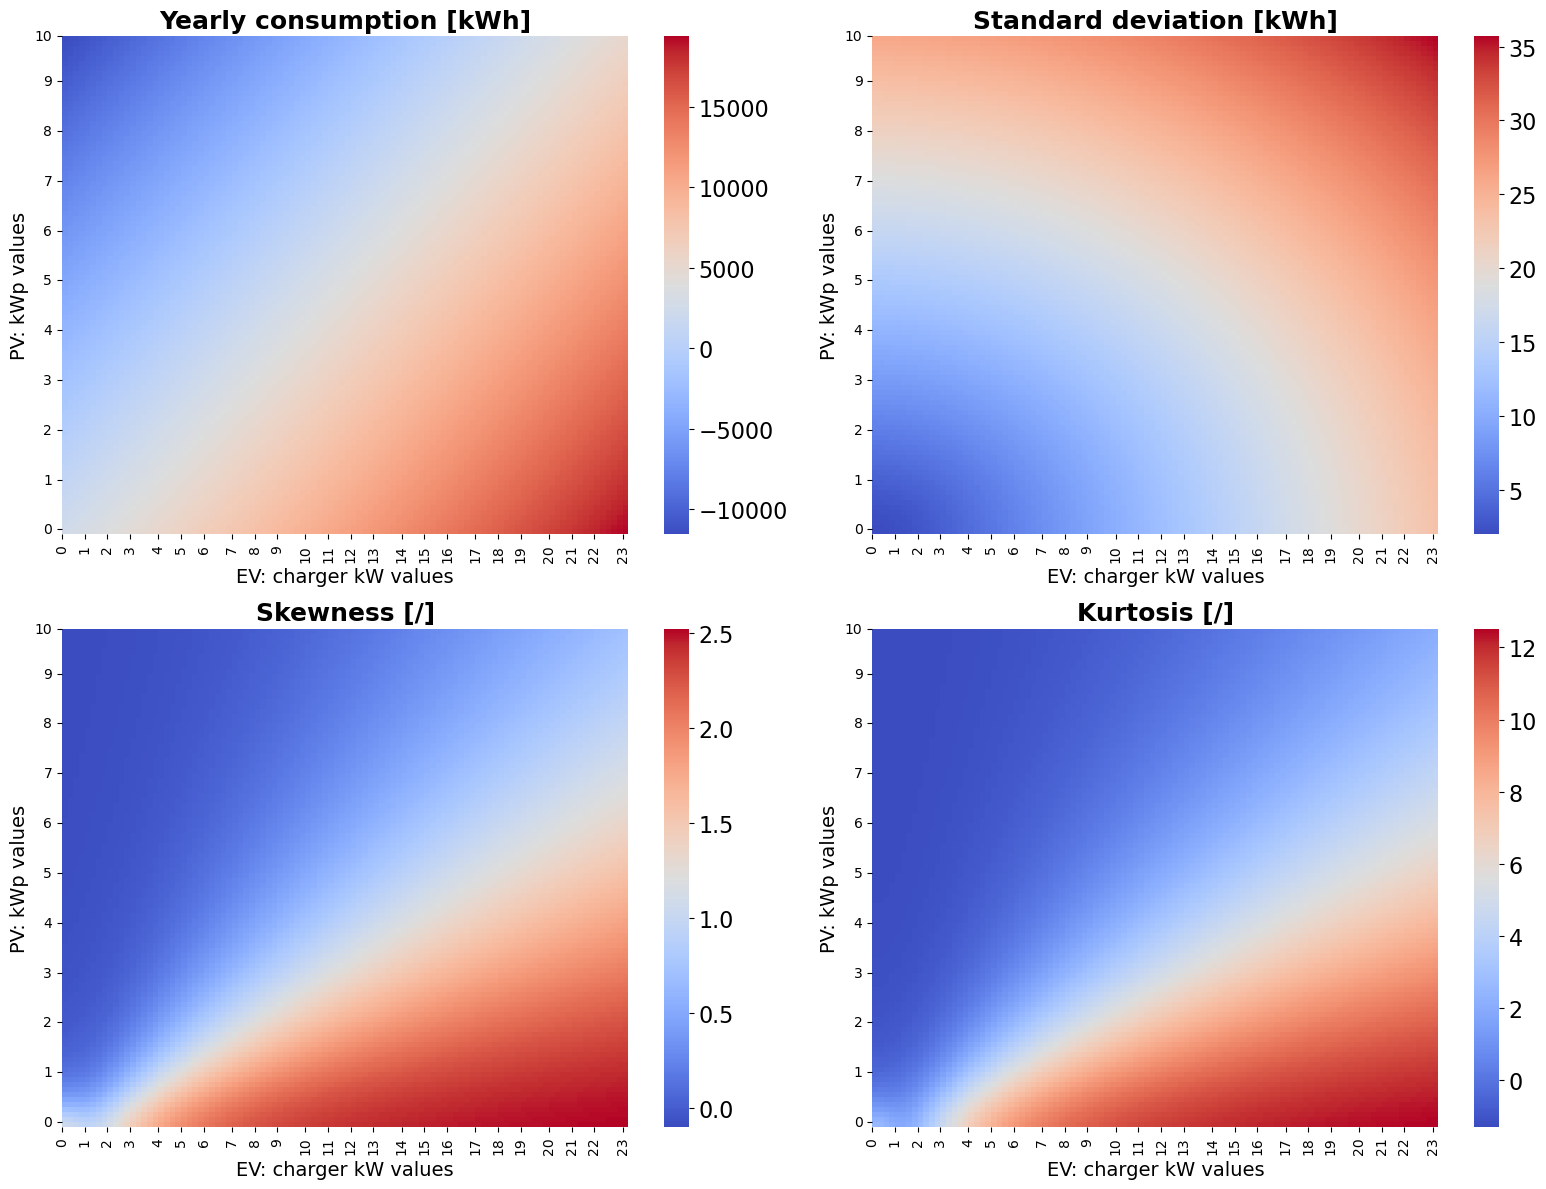

C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\1903915582.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_3.loc['Load'][0], daily_metrics_consumer_3.loc['Std'][0], daily_metrics_consumer_3.loc['Skew'][0], daily_metrics_consumer_3.loc['Kurt'][0]], ["Yearly consumption [kWh]","Standard deviation [kWh]","Skewness [/]", "Kurtosis [/]"], cols=2)


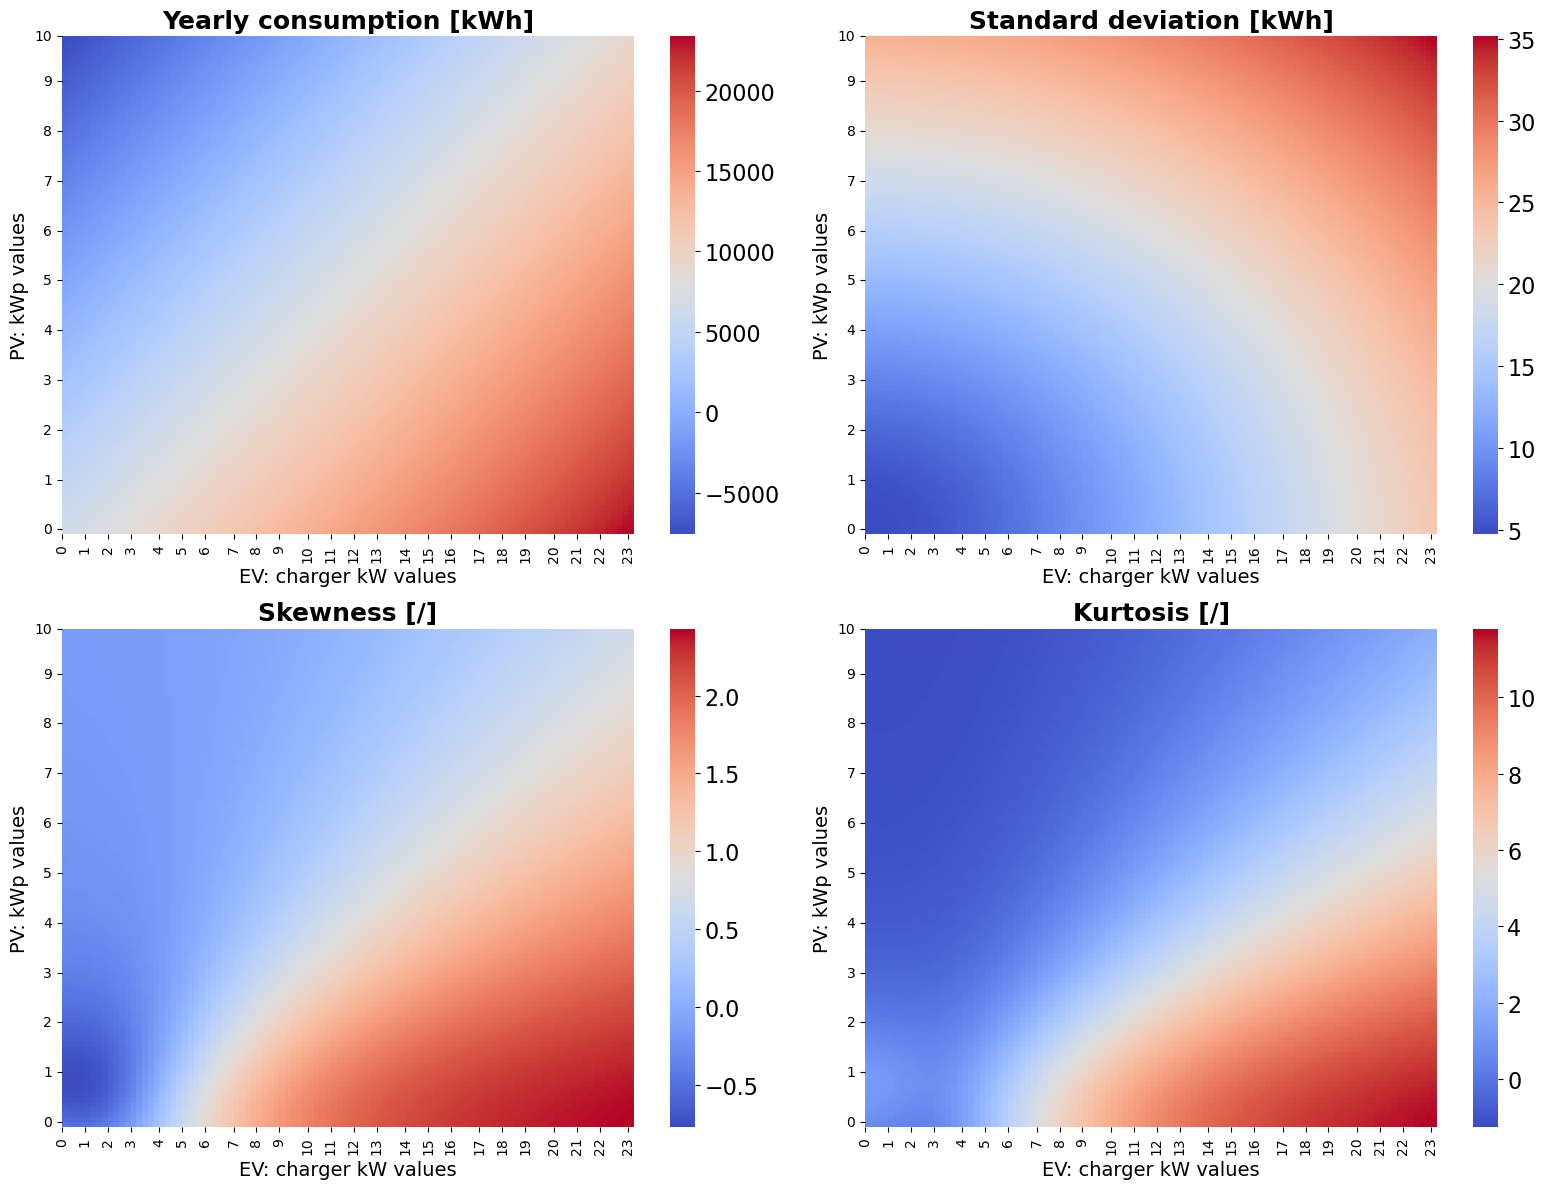

In [120]:
plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Load'][0], daily_metrics_consumer_1.loc['Std'][0], daily_metrics_consumer_1.loc['Skew'][0], daily_metrics_consumer_1.loc['Kurt'][0]], ["Yearly consumption [kWh]","Standard deviation [kWh]","Skewness [/]", "Kurtosis [/]"], cols=2)
plot_multiple_heatmaps([daily_metrics_consumer_2.loc['Load'][0], daily_metrics_consumer_2.loc['Std'][0], daily_metrics_consumer_2.loc['Skew'][0], daily_metrics_consumer_2.loc['Kurt'][0]], ["Yearly consumption [kWh]","Standard deviation [kWh]","Skewness [/]", "Kurtosis [/]"], cols=2)
plot_multiple_heatmaps([daily_metrics_consumer_3.loc['Load'][0], daily_metrics_consumer_3.loc['Std'][0], daily_metrics_consumer_3.loc['Skew'][0], daily_metrics_consumer_3.loc['Kurt'][0]], ["Yearly consumption [kWh]","Standard deviation [kWh]","Skewness [/]", "Kurtosis [/]"], cols=2)


C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\498806775.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Entropy'][0],daily_metrics_consumer_1.loc['KL'][0],daily_metrics_consumer_1.loc['TVD'][0],daily_metrics_consumer_1.loc['Wasserstein'][0],daily_metrics_consumer_1.loc['Load'][0],daily_metrics_consumer_2.loc['Entropy'][0],daily_metrics_consumer_2.loc['KL'][0],daily_metrics_consumer_2.loc['TVD'][0],daily_metrics_consumer_2.loc['Wasserstein'][0],daily_metrics_consumer_2.loc['Load'][0],daily_metrics_consumer_3.loc['Entropy'][0],daily_metrics_consumer_3.loc['KL'][0],daily_metrics_consumer_3.loc['TVD'][0],daily_metrics_consumer_3.loc['Wasserstein'][0],daily_metrics_consumer_3.loc['Load'][0]],["Shannon small consumer","KLD small consumer","TVD sm

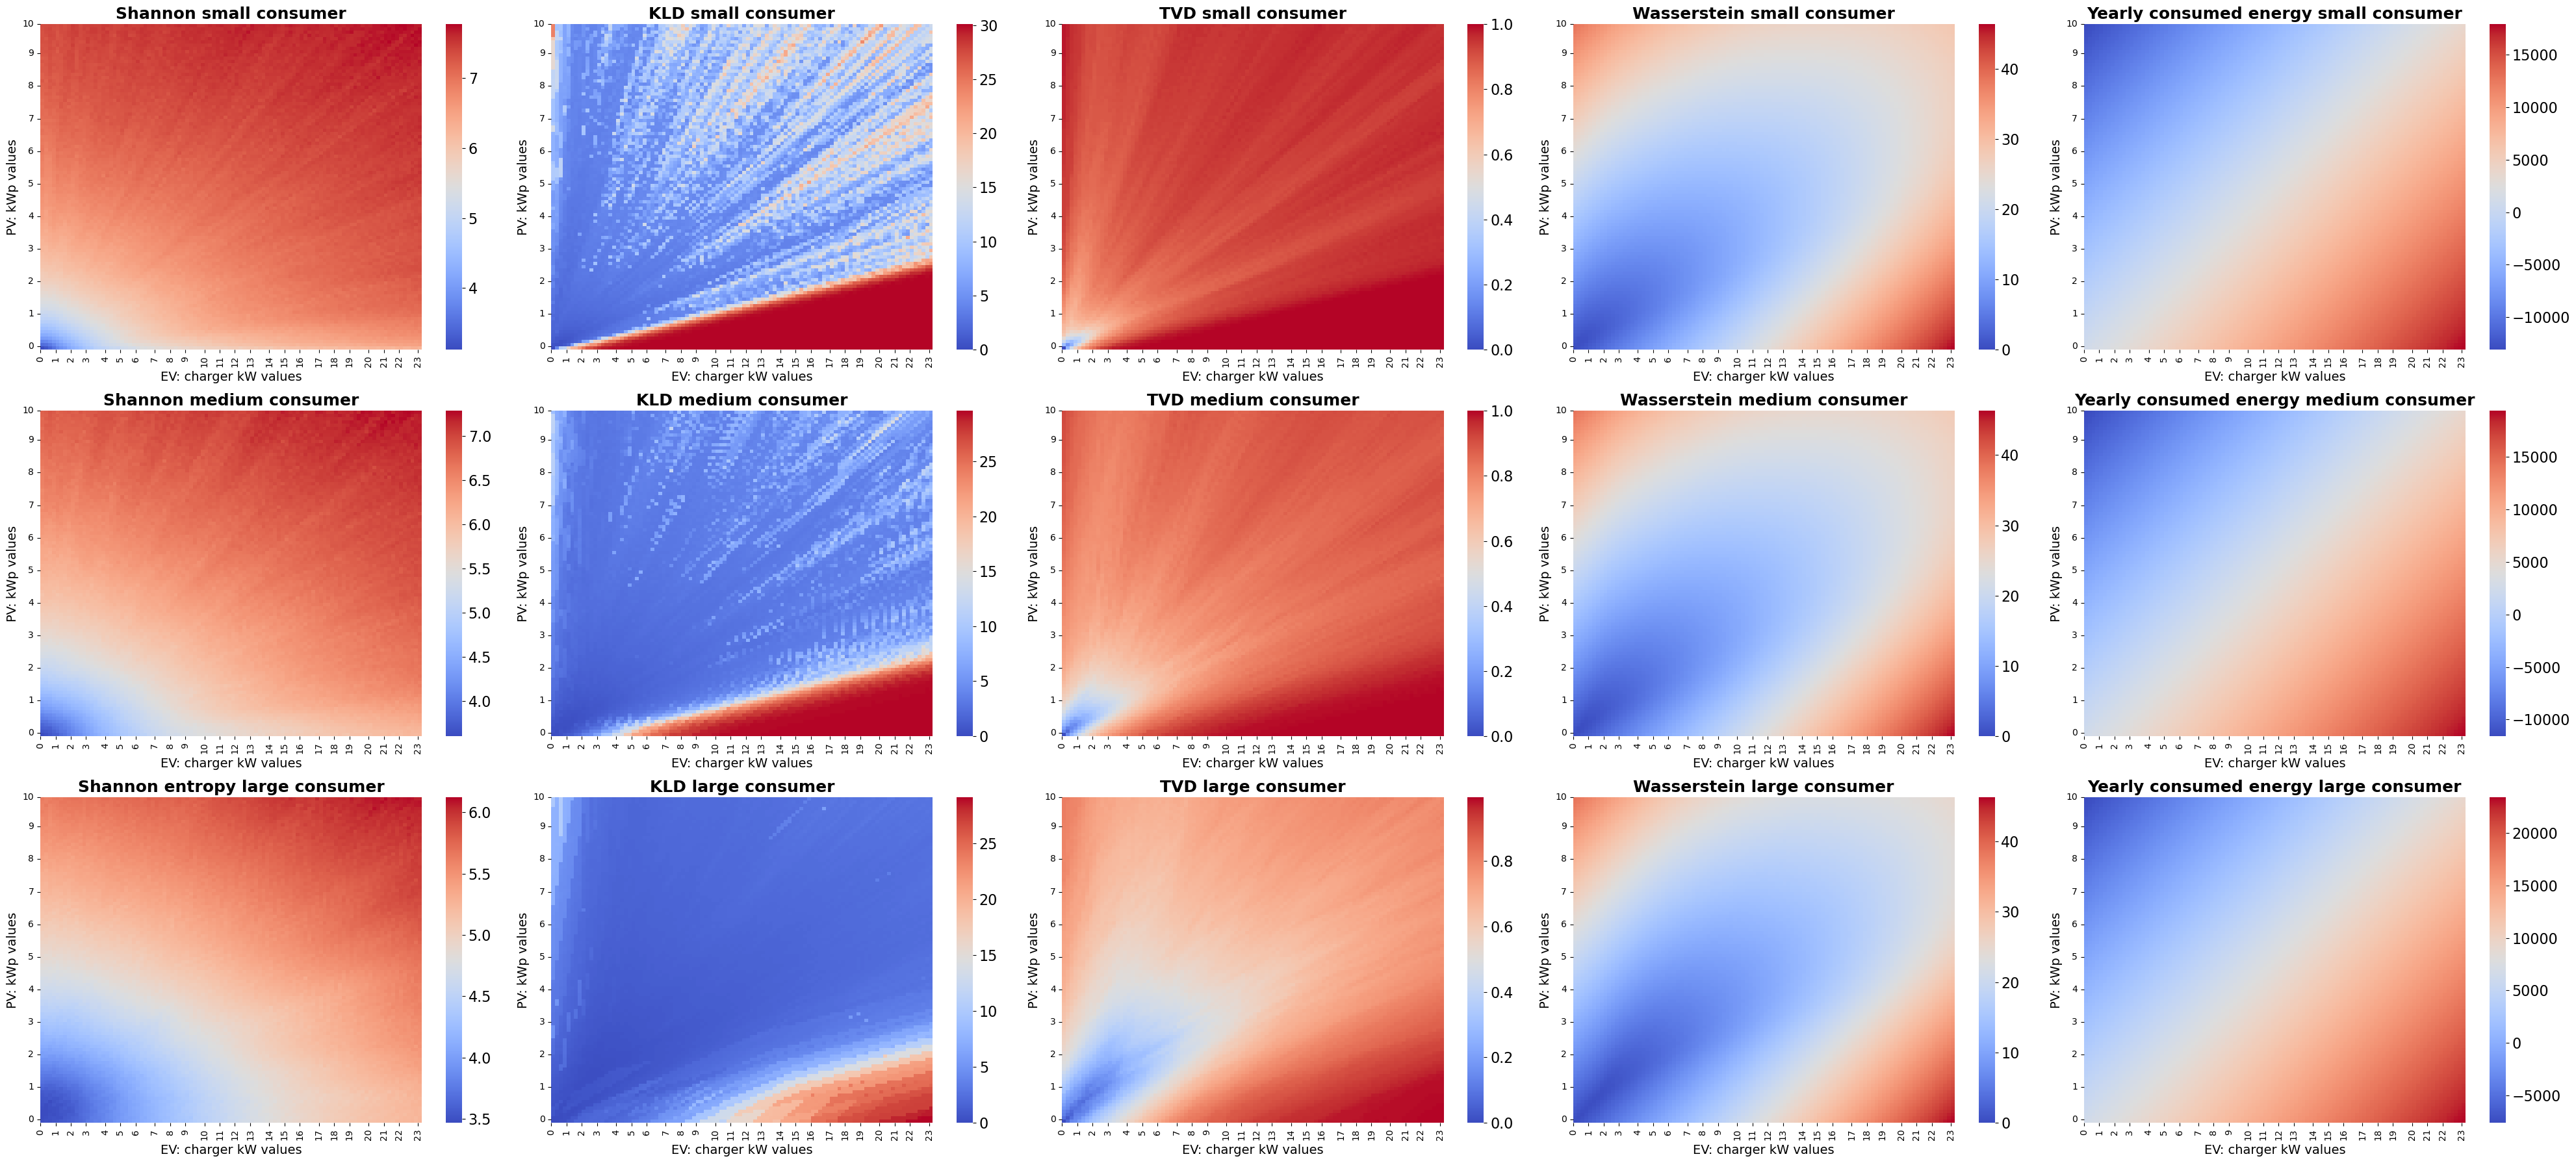

In [123]:
kwp_set = np.linspace(0, 10, 100) # From 0 to 10 with 100 steps
kw_set = np.linspace(0, 23, 100)
plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Entropy'][0],daily_metrics_consumer_1.loc['KL'][0],daily_metrics_consumer_1.loc['TVD'][0],daily_metrics_consumer_1.loc['Wasserstein'][0],daily_metrics_consumer_1.loc['Load'][0],daily_metrics_consumer_2.loc['Entropy'][0],daily_metrics_consumer_2.loc['KL'][0],daily_metrics_consumer_2.loc['TVD'][0],daily_metrics_consumer_2.loc['Wasserstein'][0],daily_metrics_consumer_2.loc['Load'][0],daily_metrics_consumer_3.loc['Entropy'][0],daily_metrics_consumer_3.loc['KL'][0],daily_metrics_consumer_3.loc['TVD'][0],daily_metrics_consumer_3.loc['Wasserstein'][0],daily_metrics_consumer_3.loc['Load'][0]],["Shannon small consumer","KLD small consumer","TVD small consumer","Wasserstein small consumer","Yearly consumed energy small consumer","Shannon medium consumer","KLD medium consumer","TVD medium consumer","Wasserstein medium consumer","Yearly consumed energy medium consumer","Shannon entropy large consumer","KLD large consumer","TVD large consumer","Wasserstein large consumer","Yearly consumed energy large consumer"],cols=5)

C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\3183951983.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Entropy'][0],daily_metrics_consumer_2.loc['Entropy'][0],daily_metrics_consumer_3.loc['Entropy'][0]],["Shannon entropy small consumer","Shannon entropy medium consumer","Shannon entropy large consumer"])


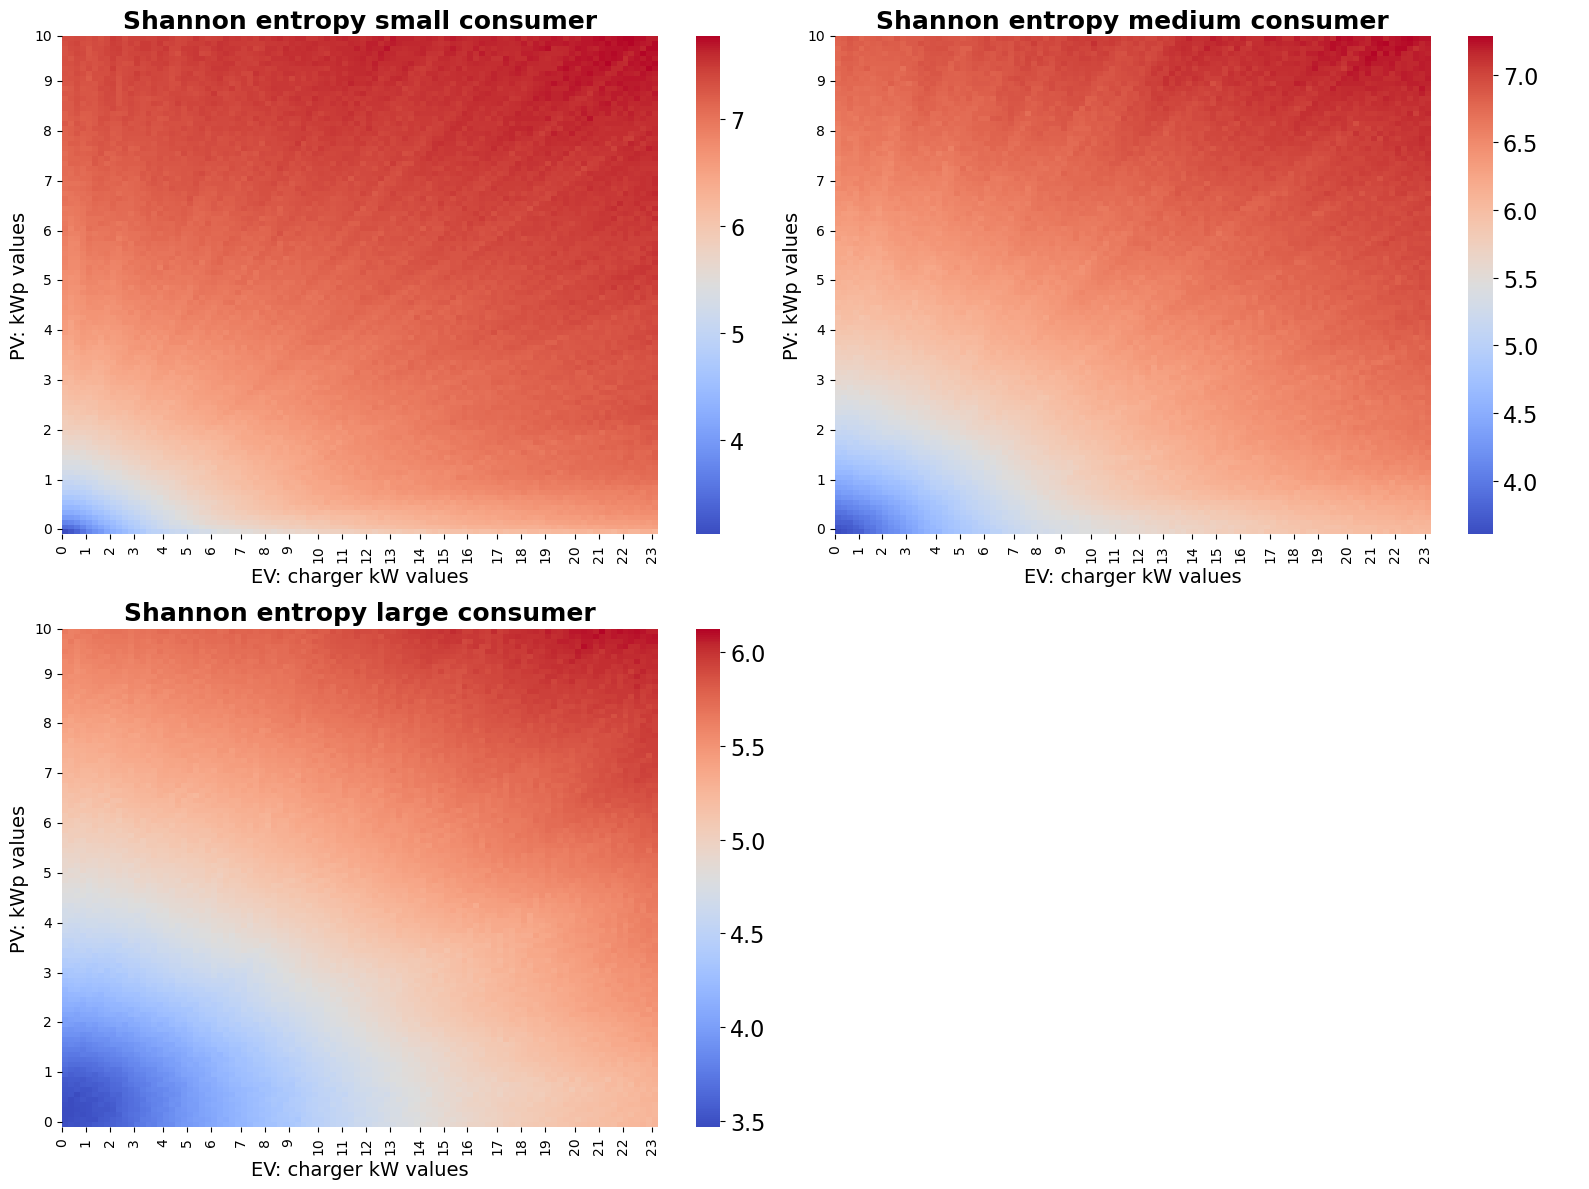

C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\3183951983.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_1.loc['KL'][0],daily_metrics_consumer_2.loc['KL'][0],daily_metrics_consumer_3.loc['KL'][0]],["Kullback–Leibler small consumer","Kullback–Leibler medium consumer","Kullback–Leibler large consumer"])


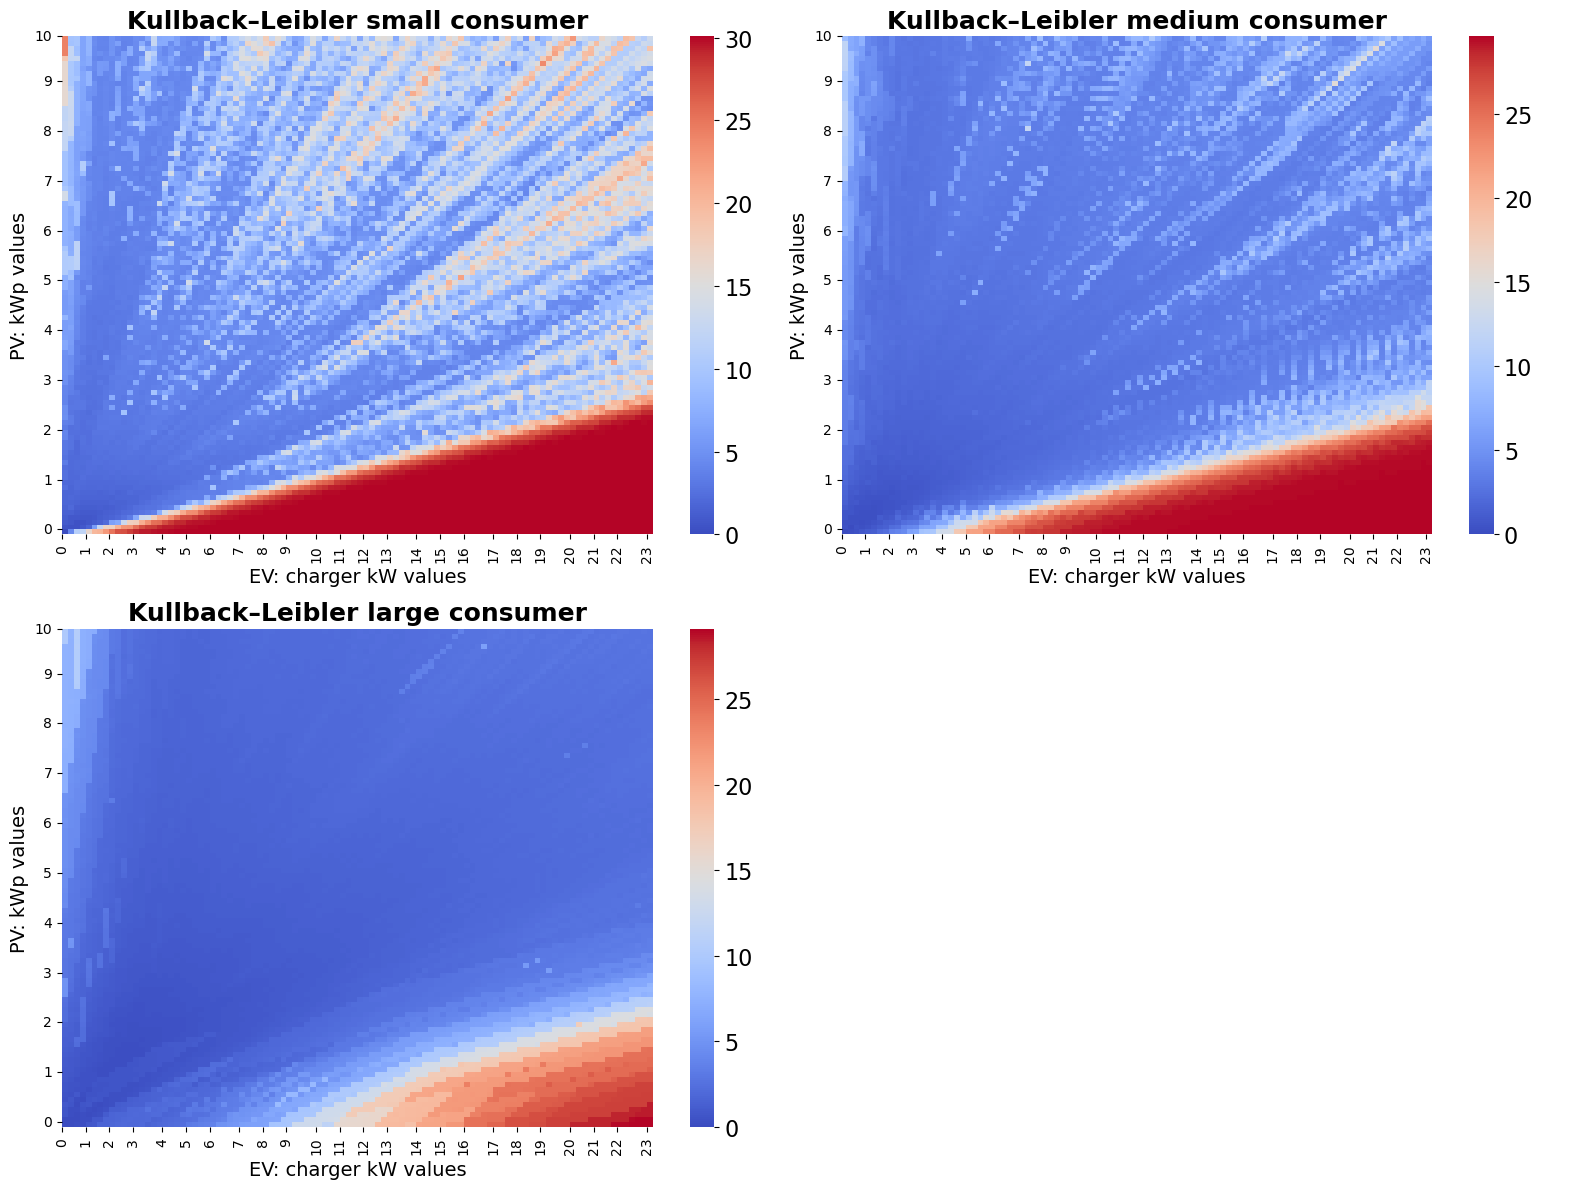

C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\3183951983.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_1.loc['TVD'][0],daily_metrics_consumer_2.loc['TVD'][0],daily_metrics_consumer_3.loc['TVD'][0]],["TVD small consumer","TVD medium consumer","TVD large consumer"])


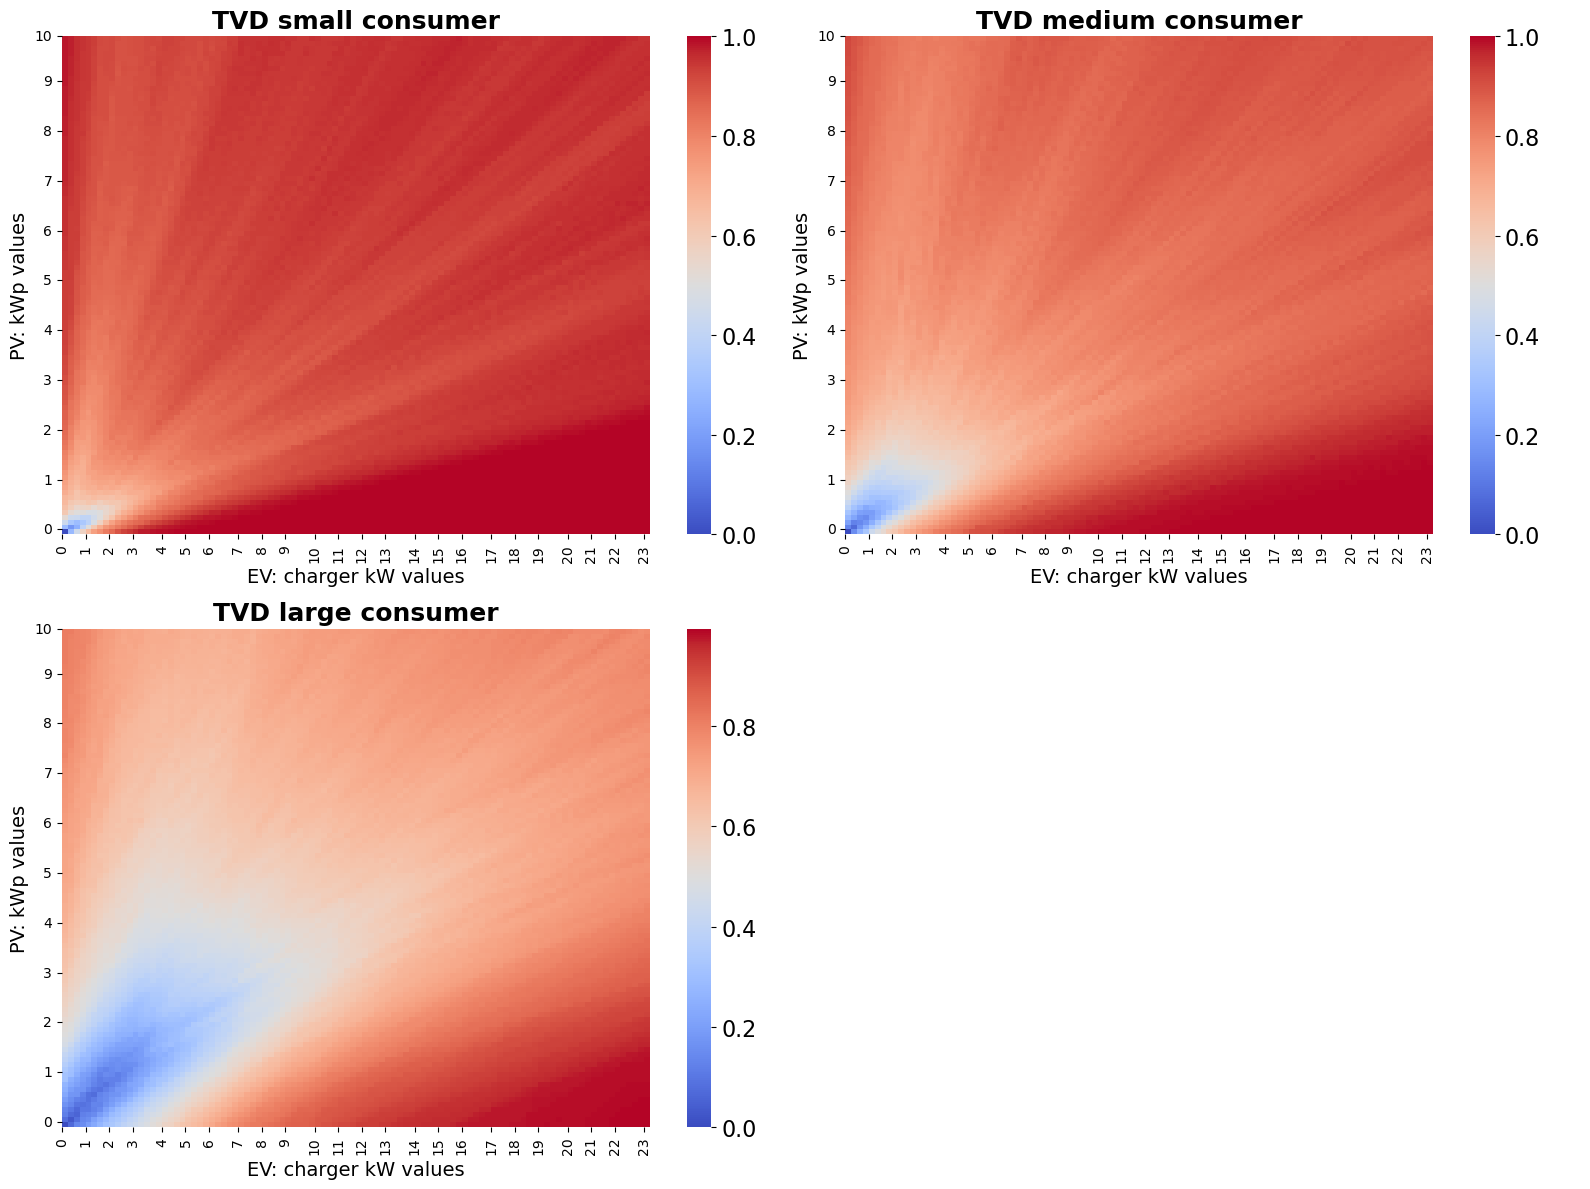

C:\Users\fiasa\AppData\Local\Temp\ipykernel_26016\3183951983.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Wasserstein'][0],daily_metrics_consumer_2.loc['Wasserstein'][0],daily_metrics_consumer_3.loc['Wasserstein'][0]],["Wasserstein small consumer","Wasserstein medium consumer","Wasserstein large consumer"])


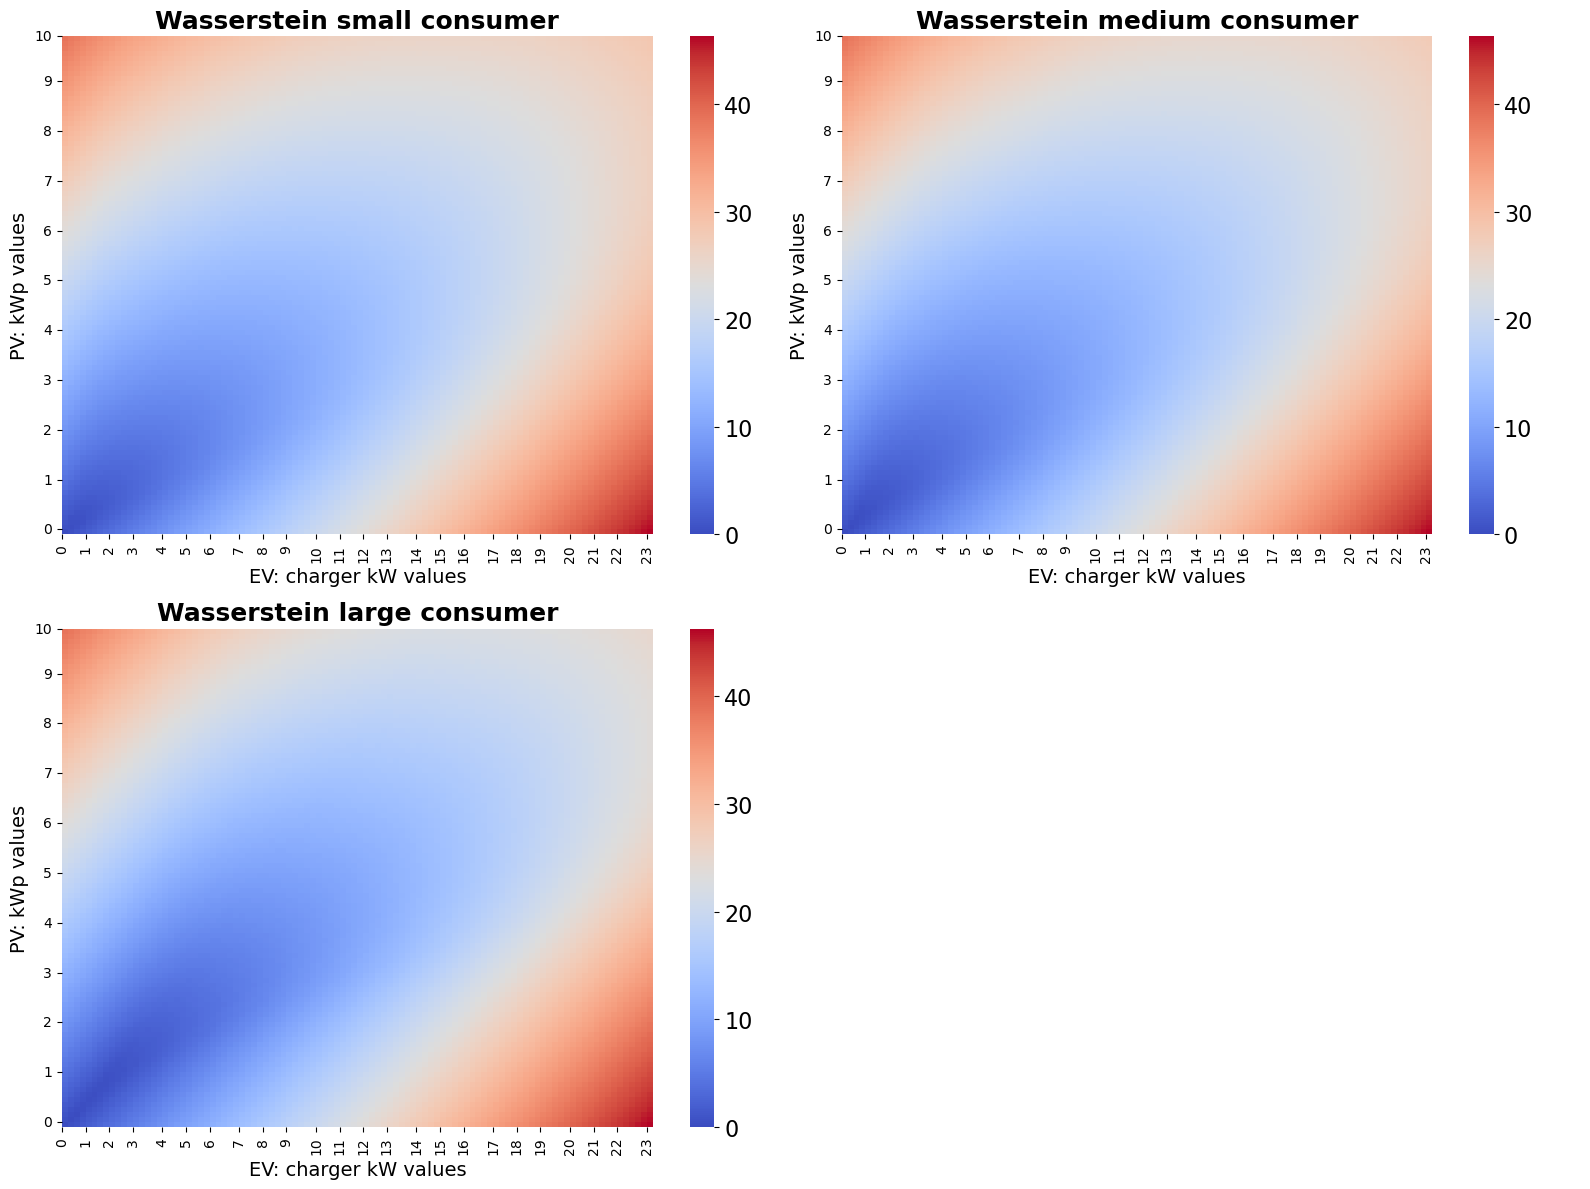

In [121]:
plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Entropy'][0],daily_metrics_consumer_2.loc['Entropy'][0],daily_metrics_consumer_3.loc['Entropy'][0]],["Shannon entropy small consumer","Shannon entropy medium consumer","Shannon entropy large consumer"])
plot_multiple_heatmaps([daily_metrics_consumer_1.loc['KL'][0],daily_metrics_consumer_2.loc['KL'][0],daily_metrics_consumer_3.loc['KL'][0]],["Kullback–Leibler small consumer","Kullback–Leibler medium consumer","Kullback–Leibler large consumer"])
plot_multiple_heatmaps([daily_metrics_consumer_1.loc['TVD'][0],daily_metrics_consumer_2.loc['TVD'][0],daily_metrics_consumer_3.loc['TVD'][0]],["TVD small consumer","TVD medium consumer","TVD large consumer"])
plot_multiple_heatmaps([daily_metrics_consumer_1.loc['Wasserstein'][0],daily_metrics_consumer_2.loc['Wasserstein'][0],daily_metrics_consumer_3.loc['Wasserstein'][0]],["Wasserstein small consumer","Wasserstein medium consumer","Wasserstein large consumer"])

Visualize PDFs

Text(0.5, 0, 'kWh')

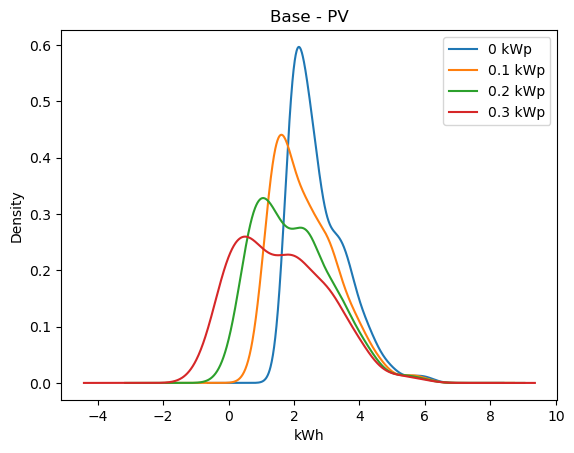

In [149]:
consumer1_flat = sum_columns(consumer1)
consumer2_flat = sum_columns(consumer2)
consumer3_flat = sum_columns(consumer3)
solargen_flat = solargen.values.flatten()
chargingprofile1_flat = chargingprofile1.values.flatten()
kwp_set = [0, 0.1,0.2,0.3]
kw_set = [0, 0.1,0.2,0.3]


for kwp in kwp_set:
    net_load = consumer1*4 - kwp*solargen
    net_load = pd.Series(sum_columns(net_load/4))
    ax = net_load.plot.kde(label = f'{kwp} kWp')      
ax.legend()
ax.set_title('Base - PV')
ax.set_xlabel('kWh')


# for kw in kw_set:
#     net_load = consumer2*4 + kw*chargingprofile1
#     net_load = pd.Series(sum_columns(net_load/4))
#     ax = net_load.plot.kde(label = f'{kw} charger kW')      
# ax.legend()
# ax.set_title('Base + EV')
# ax.set_xlabel('kWh')


Evolution of metrics with PV seperatly

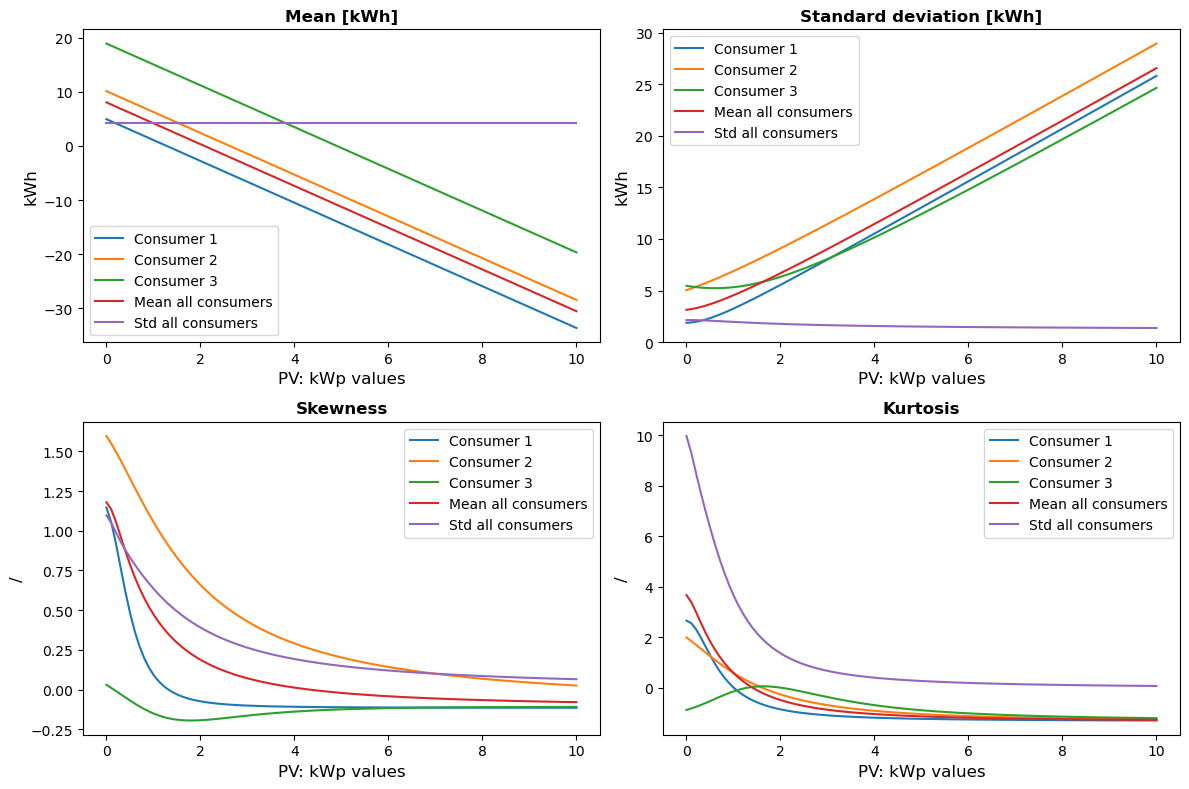

In [233]:
kwp_set = np.linspace(0, 10, 100)

def daily_metrics_M_PV(consumer,kwp_set,solargen):
    min_pv = []
    max_pv = []
    load = []
    std_pv = []
    skew_pv = []
    kurt_pv = []
    var = []
    pv = []
    for kwp in kwp_set:
        net_load = consumer-((kwp*solargen)/4)
        net_load = sum_columns(net_load)
        load.append(net_load.sum())
        std_pv.append(net_load.std())
        skew_pv.append(net_load.skew())
        kurt_pv.append(net_load.kurt())
        var.append(net_load.var())
        min_pv.append(net_load.min())
        max_pv.append(net_load.max())
        pv.append(((kwp*solargen)/4).sum().sum())

    return load, std_pv, skew_pv, kurt_pv, var, pv

def mean_metrics_all_consumers(all_consumers,kwp_set,solargen):
    mean_all_consumers = pd.DataFrame()
    std_all_consumers = pd.DataFrame()
    skew_all_consumers = pd.DataFrame()
    kurt_all_consumers = pd.DataFrame()

    for consumer in all_consumers:
        mean = []
        std = []
        skew = []
        kurt = []
        for kwp in kwp_set:
            net_load = consumer-((kwp*solargen)/4)
            net_load = sum_columns(net_load)
            mean.append(net_load.mean())
            std.append(net_load.std())
            skew.append(net_load.skew())
            kurt.append(net_load.kurt())
        mean_all_consumers = pd.concat([mean_all_consumers, pd.DataFrame([mean])])
        std_all_consumers = pd.concat([std_all_consumers, pd.DataFrame([std])])
        skew_all_consumers = pd.concat([skew_all_consumers, pd.DataFrame([skew])])
        kurt_all_consumers = pd.concat([kurt_all_consumers, pd.DataFrame([kurt])])

    return [mean_all_consumers.mean(), std_all_consumers.mean(), skew_all_consumers.mean(), kurt_all_consumers.mean()], [mean_all_consumers.std(), std_all_consumers.std(), skew_all_consumers.std(), kurt_all_consumers.std()]        

In [ ]:
daily_metrics_consumer1 = daily_metrics_M_PV(consumer1, kwp_set, solargen)
daily_metrics_consumer2 = daily_metrics_M_PV(consumer2, kwp_set, solargen)
daily_metrics_consumer3 = daily_metrics_M_PV(consumer3, kwp_set, solargen)
#daily_metrics_all_consumers = mean_metrics_all_consumers(all_consumers,kwp_set,solargen)


### Plot
metrics = [0, 1, 2, 3, 4, 5]
titles = ['Annual consumption [kWh]', 'Standard deviation [kWh]', 'Skewness', 'Kurtosis', 'Variance [kWh²]', 'Injected PV [kWh]']  # Titles for each plot

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    metric = metrics[i]
    ax.set_title(titles[i], fontsize=12, weight='bold')
    ax.set_xlabel("PV: kWp values", fontsize=12)
    y_text = "kWh" if metrics[i] in [0, 1] else "/"
    ax.set_ylabel(y_text, fontsize=12)

    ax.plot(kwp_set, daily_metrics_consumer1[metric], label='Small consumer')
    ax.plot(kwp_set, daily_metrics_consumer2[metric], label='Medium consumer')
    ax.plot(kwp_set, daily_metrics_consumer3[metric], label='Large consumer')
    # ax.plot(kwp_set, metrics_all_consumers[0][metric], label='Mean all consumers')
    # ax.plot(kwp_set, metrics_all_consumers[1][metric], label='Std all consumers')
    ax.legend() 

plt.tight_layout()
plt.show()

Evolution of metrics with EV seperatly

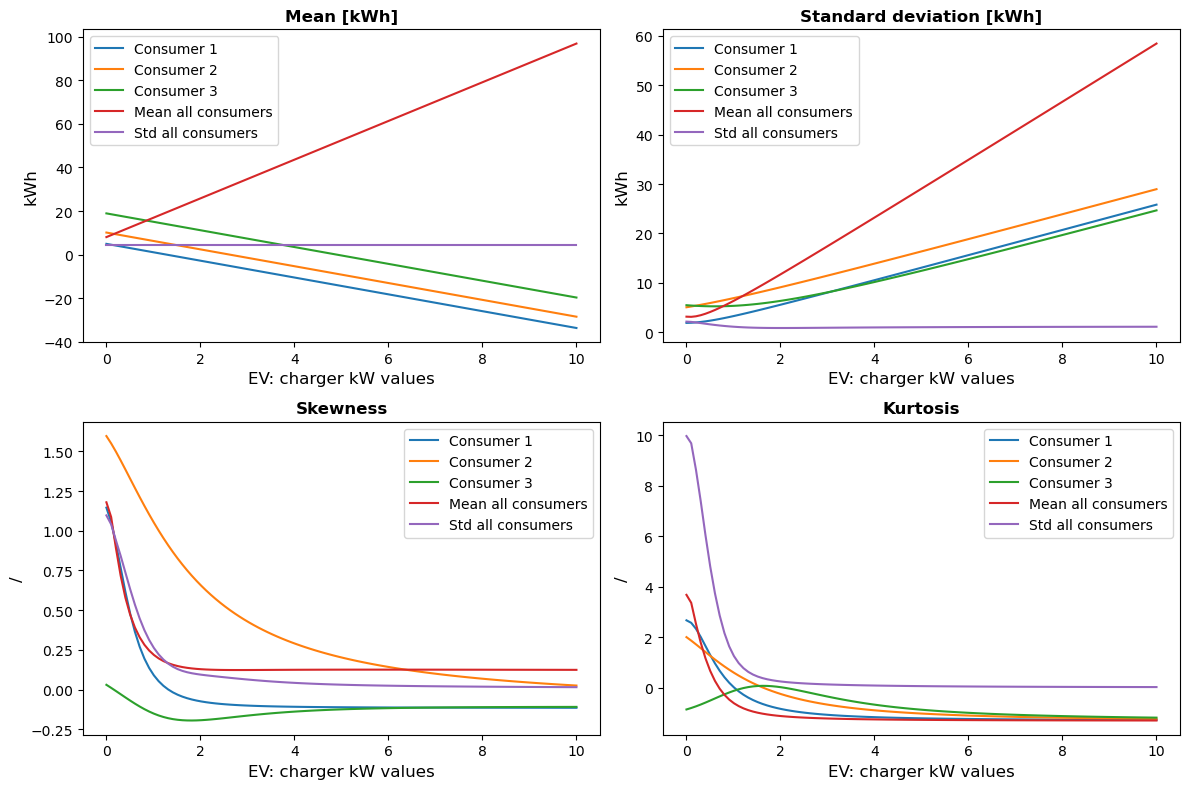

In [ ]:
kw_set = np.linspace(0, 23, 100)

def daily_metrics_M_EV(consumer, kw_set, chargingprofile):
    total_load = []
    min_pv = []
    max_pv = []
    q05 = []
    q95 = []
    mean_pv = []
    std_pv = []
    skew_pv = []
    kurt_pv = []
    var = []
    ev = []
    for kw in kw_set:
        net_load = consumer+((kw*chargingprofile)/4)
        net_load = sum_columns(net_load)
        total_load.append(net_load.sum())
        min_pv.append(net_load.min())
        max_pv.append(net_load.max())
        q05.append(net_load.quantile(.05))
        q95.append(net_load.quantile(.95))
        mean_pv.append(net_load.mean())
        std_pv.append(net_load.std())
        skew_pv.append(net_load.skew())
        kurt_pv.append(net_load.kurt())
        ev.append(((kw*chargingprofile)/4).sum().sum())
    return total_load, std_pv, skew_pv, kurt_pv, var, ev

def mean_metrics_all_consumers(all_consumers,kw_set,chargingprofile):
    mean_all_consumers = pd.DataFrame()
    std_all_consumers = pd.DataFrame()
    skew_all_consumers = pd.DataFrame()
    kurt_all_consumers = pd.DataFrame()

    for consumer in all_consumers:
        mean = []
        std = []
        skew = []
        kurt = []
        for kw in kw_set:
            net_load = consumer+((kw*chargingprofile)/4)
            net_load = sum_columns(net_load)
            mean.append(net_load.mean())
            std.append(net_load.std())
            skew.append(net_load.skew())
            kurt.append(net_load.kurt())
        mean_all_consumers = pd.concat([mean_all_consumers, pd.DataFrame([mean])])
        std_all_consumers = pd.concat([std_all_consumers, pd.DataFrame([std])])
        skew_all_consumers = pd.concat([skew_all_consumers, pd.DataFrame([skew])])
        kurt_all_consumers = pd.concat([kurt_all_consumers, pd.DataFrame([kurt])])

    return [mean_all_consumers.mean(), std_all_consumers.mean(), skew_all_consumers.mean(), kurt_all_consumers.mean()], [mean_all_consumers.std(), std_all_consumers.std(), skew_all_consumers.std(), kurt_all_consumers.std()]


In [ ]:
daily_metrics_consumer1 = daily_metrics_M_EV(consumer1, kw_set, chargingprofile1)
daily_metrics_consumer2 = daily_metrics_M_EV(consumer2, kw_set, chargingprofile1)
daily_metrics_consumer3 = daily_metrics_M_EV(consumer3, kw_set, chargingprofile1)
# metrics_all_consumers = mean_metrics_all_consumers(all_consumers,kw_set,solargen)

### Plot
metrics = [0, 1, 2, 3, 4, 5]
titles = ['Annual consumption [kWh]', 'Standard deviation [kWh]', 'Skewness', 'Kurtosis', 'Variance [kWh²]', 'Consumption of EV [kWh]']  # Titles for each plot

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    metric = metrics[i]
    ax.set_title(titles[i], fontsize=12, weight='bold')
    ax.set_xlabel("EV: charger kW values", fontsize=12)
    y_text = "kWh" if metrics[i] in [0, 1] else "/"
    ax.set_ylabel(y_text, fontsize=12)

    ax.plot(kw_set, daily_metrics_consumer1[metric], label='Small consumer')
    ax.plot(kw_set, daily_metrics_consumer2[metric], label='Medium consumer')
    ax.plot(kw_set, daily_metrics_consumer3[metric], label='Large consumer')
    # ax.plot(kw_set, metrics_all_consumers[0][metric], label='Mean all consumers')
    # ax.plot(kw_set, metrics_all_consumers[1][metric], label='Std all consumers')
    ax.legend() 

plt.tight_layout()
plt.show()

       